In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import t, pearsonr, spearmanr, kendalltau
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis 
import statsmodels.api as sm
import re
sns.set()

Importing DataFrame

In [50]:
df_nlu = pd.read_csv('non-lock_up')
df_lu = pd.read_csv('lock_up')
df_nlu.drop(columns=df_nlu.columns[99:], inplace=True)
df_lu.drop(columns=df_lu.columns[99:], inplace=True)

Formating Dataframe

In [39]:
def preprocess_dataframe(df):
    
    # Remove percentages and inequality signs from all cells in the DataFrame
    df_p = df.applymap(lambda x: re.sub(r'%|<|>|<=|>=', '', str(x)))

    # Convert possible cells to floats and remove non-float cells
    df_p = df_p.apply(pd.to_numeric, errors='coerce')

    # Remove columns with all NaN values
    df_p = df_p.dropna(axis=1, how='all')

    # Remove the first three columns using iloc
    df_p = df_p.iloc[:, 3:]

    return df_p

# Assuming your DataFrame is named 'df'
p_df_lu = preprocess_dataframe(df_lu)
p_df_nlu = preprocess_dataframe(df_nlu)

Bootstrap

In [40]:
def bootstrap_for_dataframe(df, num_samples=10000, statistic=np.mean):
    # Create an empty DataFrame to store bootstrap results
    bootstrap_samples = pd.DataFrame()

    # Iterate over each column in the DataFrame
    for column in df.columns:
        # Remove NaN values and convert to NumPy array
        data = df[column].dropna().values

        # Perform bootstrap resampling
        bootstrap_means = []
        for _ in range(num_samples):
            bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
            bootstrap_statistic = statistic(bootstrap_sample)
            bootstrap_means.append(bootstrap_statistic)

        # Store the bootstrap results for each column in the DataFrame
        bootstrap_samples[column] = bootstrap_means

    return bootstrap_samples


In [41]:
bootstrap_results_nlu = bootstrap_for_dataframe(p_df_nlu, num_samples=10000, statistic=np.mean)
bootstrap_results_lu = bootstrap_for_dataframe(p_df_lu, num_samples=10000, statistic=np.mean)

Data Analysis

In [ ]:
display(bootstrap_results_nlu)
display(bootstrap_results_lu)

In [ ]:
import pandas as pd
from scipy.stats import f_oneway

def anova_test_for_corresponding_columns(df1, df2):
    # Check if the dataframes have the same number of columns and column names
    if df1.shape[1] != df2.shape[1] or not all(df1.columns == df2.columns):
        raise ValueError("Both dataframes should have the same number of columns with the same column names.")

    # Initialize an empty DataFrame to store the ANOVA results
    anova_results = pd.DataFrame(columns=['Column', 'F-Statistic', 'P-Value'])

    # Perform ANOVA test for each corresponding pair of columns
    for column in df1.columns:
        # Extract data from corresponding columns of both dataframes
        data1 = df1[column].dropna()
        data2 = df2[column].dropna()

        # Perform the ANOVA test
        f_statistic, p_value = f_oneway(data1, data2)

        # Store the results in the DataFrame
        anova_results = anova_results.append({
            'Column': column,
            'F-Statistic': f_statistic,
            'P-Value': p_value
        }, ignore_index=True)

    return anova_results

# Example usage:
# Assuming your DataFrames are named 'df1' and 'df2'
results = pd.DataFrame(anova_test_for_corresponding_columns(bootstrap_results_nlu, bootstrap_results_lu))


PCA Analysis

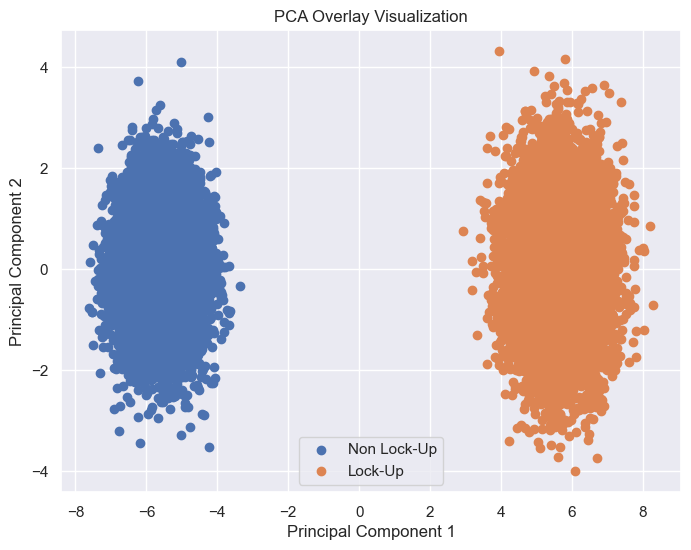

In [59]:
def pca_and_overlay_plot(df1, df2, num_components=2):
    # Combine the dataframes into a single dataframe
    combined_df = pd.concat([df1, df2], ignore_index=True)

    # Extract the numeric data for PCA
    numeric_data = combined_df.select_dtypes(include=[np.number]).values

    # Standardize the data to have mean=0 and variance=1
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(numeric_data)

    # Perform PCA
    pca = PCA(n_components=num_components)
    principal_components = pca.fit_transform(standardized_data)

    # Create a new dataframe to store the PCA results
    pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(num_components)])

    # Add a new column to indicate the source dataframe
    pca_df['DataFrame'] = ['DataFrame 1'] * len(df1) + ['DataFrame 2'] * len(df2)

    # Plot the PCA results with overlay and dataframe names as labels
    plt.figure(figsize=(8, 6))
    for dataframe in pca_df['DataFrame'].unique():
        df_subset = pca_df[pca_df['DataFrame'] == dataframe]
        plt.scatter(df_subset['PC1'], df_subset['PC2'], label=dataframe)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(['Non Lock-Up', 'Lock-Up'])
    plt.title('PCA Overlay Visualization')
    plt.grid(True)
    plt.show()

    return pca_df

# Example usage:
# Assuming your DataFrames are named 'df1' and 'df2'
pca_results = pca_and_overlay_plot(bootstrap_results_nlu, bootstrap_results_lu)